In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import YlGn_9

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [3]:
# 1. maizsim outputs
df_sims = pd.read_csv('/home/disk/eos8/ach315/upscale/data/sims_6105.csv', dtype={'site':'str'})

# 2. site & site-years
df_sites_all = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', dtype={'site': str})
siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered.csv', dtype={'site':str})
df_sites = df_sites_all[df_sites_all.site.isin(siteyears.site)]
df_sites.reset_index(inplace=True, drop=True)

# 3. weather
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', dtype={'site': 'str'}, index_col=0)
df_wea.reset_index(inplace=True, drop=True)

# 4. parameter
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/params/param_opt.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params['cvar'] = df_params.index

# 5. merge all
df_sims_params = pd.merge(df_sims, df_params, on='cvar')
df_sims_params_sites = pd.merge(df_sims_params, df_sites, on='site')
df_all = pd.merge(df_sims_params_sites, df_wea, on=['site','year'])

# 6. group by cvars or site
df_sims_sitemean = df_all.groupby(['site']).mean()
df_sims_yearmean = df_all.groupby(['year']).mean()
df_sims_cvarmean = df_all.groupby(['cvar']).mean()

# 7. data with simulations that reached maturity only
df_matured = df_all[df_all.note == '"Matured"']

### Cluster based on weather data

In [159]:
df_wea_gbysite = df_wea.groupby(['site']).mean()
df_wea_gbysite.head()

year       temp         rh      precip      solrad       vpd  \
site                                                                          
722070  1977.636364  23.448432  73.102946  741.059091  229.759914  0.790738   
722080  1983.480000  23.145051  75.116173  925.895500  229.412050  0.717446   
722140  1977.157895  23.636775  75.251082  898.192982  231.491352  0.735354   
722170  1977.090909  22.890561  71.303964  526.993939  230.217785  0.815847   
722180  1976.277778  22.125387  72.198567  533.709259  229.844983  0.753086   

        class  tzone     lat     lon  years          area  perct_irri  
site                                                                   
722070    1.0   -5.0  32.117 -81.200   22.0   2445.923794    6.585904  
722080    1.0   -5.0  32.900 -80.033   25.0  10052.406880    5.735219  
722140    1.0   -5.0  30.400 -84.350   19.0   9510.127270   13.348148  
722170    1.0   -5.0  32.683 -83.650   22.0   2731.632292   18.039572  
722180    1.0   -5.0  33.367 -81.967   18.0   5940.794366    8.403471

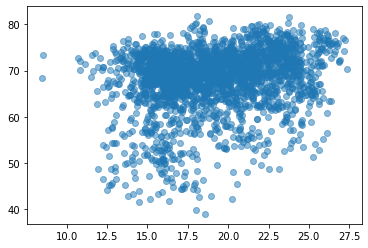

In [161]:
plt.scatter(df_wea.temp, df_wea.rh, alpha=0.5)

### PCA: cultivar rows as samples & site columns as features

In [615]:
# all data
cultivars = range(100)

cvar_rows = []
for cvar in cultivars:
    cvar_row = df_all.groupby(['cvar', 'site']).mean().query(f'cvar=={cvar}').dm_ear
    cvar_rows.append(cvar_row)

In [599]:
# only with matured data
cultivars = range(100)

sites = df_sites.site[:-1]
df_allsites = pd.DataFrame({'site':sites})

cvar_rows = []
for cvar in cultivars:
    cvar_row = df_matured.groupby(['cvar', 'site']).mean().query(f'cvar=={cvar}').dm_ear
    df_cvar_row = pd.DataFrame(cvar_row).reset_index()
    cvar_row = list(df_allsites.merge(df_cvar_row, how='left', on='site').dm_ear)
    cvar_rows.append(cvar_row)

In [604]:
df_pca = pd.DataFrame(np.matrix(cvar_rows))
df_pca.head()

0        1          2          3          4          5          6    \
0  66.596818  70.1572  70.965263  60.676818  57.915000  77.230455  55.103333   
1  39.249545  41.5208  35.559474  33.041364  39.301667  40.129545  36.871333   
2  84.572273  88.6124  79.801579  76.963636  80.088333  88.762273  77.034000   
3   9.339545   9.6036  11.001579   8.808636  10.873889   9.642273  11.096000   
4  83.769091  87.2048  90.828421  80.665455  78.870556  91.280455  77.278000   

         7          8          9    ...        119      120        121  \
0  74.030556  45.781818  66.820909  ...  42.502917  27.4960  27.214762   
1  36.972778  46.268182  35.313636  ...  39.761111  67.1400  44.290625   
2  85.515556  89.378182  73.491818  ...  58.843043  47.6875  53.983889   
3  10.816111  11.620000   9.867273  ...  21.113182  33.2700  22.214737   
4  87.112778  73.721818  84.333636  ...  34.060000  23.4550  27.770526   

         122        123        124        125        126        127        128  
0  36.115000  24.646111  16.342381  19.476154  25.206190  25.950556  18.300952  
1  57.298000  39.946000  29.400588        NaN  47.891111  36.471667  40.474545  
2  61.255714  54.258824  50.590000  35.630000  46.651176  48.461538  56.964667  
3  33.425714  26.635625  15.452222        NaN  28.552857  27.194615  20.315333  
4  35.700000  21.960667  14.932778        NaN  20.098571  17.521429  18.821250  

[5 rows x 129 columns]

In [605]:
ear_sitemean = df_pca.mean(axis=0)
print(len(ear_sitemean))

129


In [609]:
# Standardize
ear_sitemean = df_pca.mean(axis=0)
sites = list(np.arange(129))

ear_std_sites = []
for site in sites:
    ear_std_site = preprocessing.scale(df_pca.iloc[:,site])
    ear_std_sites.append(ear_std_site)
ear_std_sites = np.transpose(ear_std_sites)

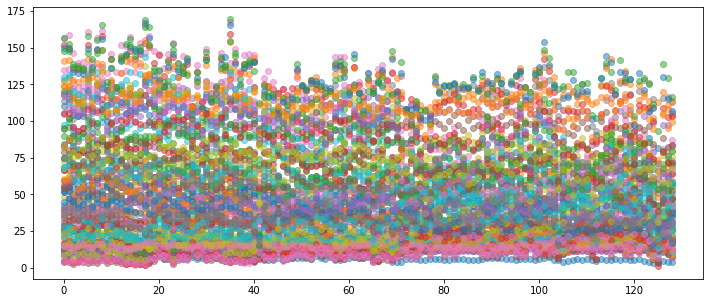

In [495]:
fig = plt.figure(figsize=(12,5))
for i in np.arange(100):
    plt.plot(df_pca.iloc[i,:], 'o', alpha=0.5)

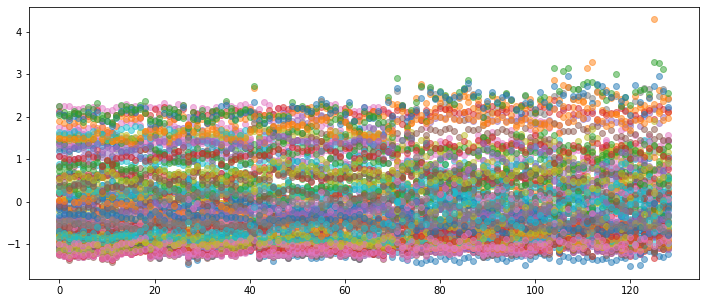

In [488]:
fig = plt.figure(figsize=(12,5))
for i in np.arange(100):
    plt.plot(ear_std_sites[i], 'o', alpha=0.5)

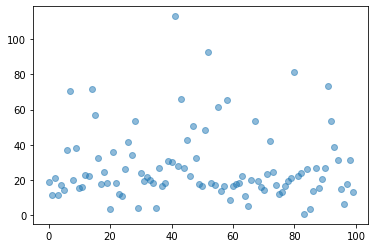

In [500]:
plt.plot(df_pca[125], 'o', alpha=0.5)

In [617]:
df_all_grouped = df_all.groupby(['cvar', 'site', 'year']).mean()

In [621]:
df_all_grouped.head()

jday  time  leaves  mature_lvs  drop_lvs      LA  LA_dead  \
cvar site   year                                                               
0    722070 1961  22487    15    23.0          23        19  306.79  5932.15   
            1962  22846    17    23.0          23        18  304.85  5920.10   
            1965  23947     2    23.0          23        18  307.48  5917.25   
            1970  25768    15    23.0          23        19  293.14  5675.60   
            1971  26136    16    23.0          23        19  308.80  5972.98   

                   LAI     RH  leaf_WP  ...  precip      solrad       vpd  \
cvar site   year                        ...                                 
0    722070 1961  0.25  43.69  -1.7841  ...   881.8  234.060642  0.701216   
            1962  0.24  56.31  -1.9540  ...   973.0  233.714984  0.723302   
            1965  0.25  85.51  -0.4011  ...   226.6  229.640454  0.712474   
            1970  0.23  58.62  -1.8298  ...   275.7  228.436228  0.820531   
            1971  0.25  71.70  -0.6230  ...   564.4  227.596440  0.805592   

                  class_y  tzone_y   lat_y  lon_y  years_y       area_y  \
cvar site   year                                                          
0    722070 1961        1       -5  32.117  -81.2       22  2445.923794   
            1962        1       -5  32.117  -81.2       22  2445.923794   
            1965        1       -5  32.117  -81.2       22  2445.923794   
            1970        1       -5  32.117  -81.2       22  2445.923794   
            1971        1       -5  32.117  -81.2       22  2445.923794   

                  perct_irri_y  
cvar site   year                
0    722070 1961      6.585904  
            1962      6.585904  
            1965      6.585904  
            1970      6.585904  
            1971      6.585904  

[5 rows x 76 columns]

In [625]:
df_all_grouped.query('cvar==0 and site=="722070"').dm_ear

cvar  site    year
0     722070  1961    69.68
              1962    75.79
              1965    63.11
              1970    60.22
              1971    73.34
              1972    39.96
              1973    69.17
              1974    49.81
              1975    52.41
              1976    57.56
              1977    84.93
              1978    64.84
              1979    55.26
              1980    66.26
              1981    88.62
              1982    69.22
              1983    41.36
              1984    60.97
              1985    76.95
              1992    77.10
              1993    79.78
              1995    88.79
Name: dm_ear, dtype: float64

v try plotting all years to this plot!

In [ ]:
cultivars = np.arange(100)
sites = np.arange(129)

fig = plt.figure(figsize=(20,50))
for cvar in cultivars:
    ax = fig.add_subplot(20, 5, cvar+1)
    ax.scatter(list(sites), df_pca.iloc[cvar,:], alpha=0.8, s=50,
               c=df_pca.iloc[cvar,:], cmap=YlGn_9.mpl_colormap, vmin=0, vmax=150)

    ax.set_ylim(0, 200)
    ax.set_title(cvar)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.2, hspace=0.25)

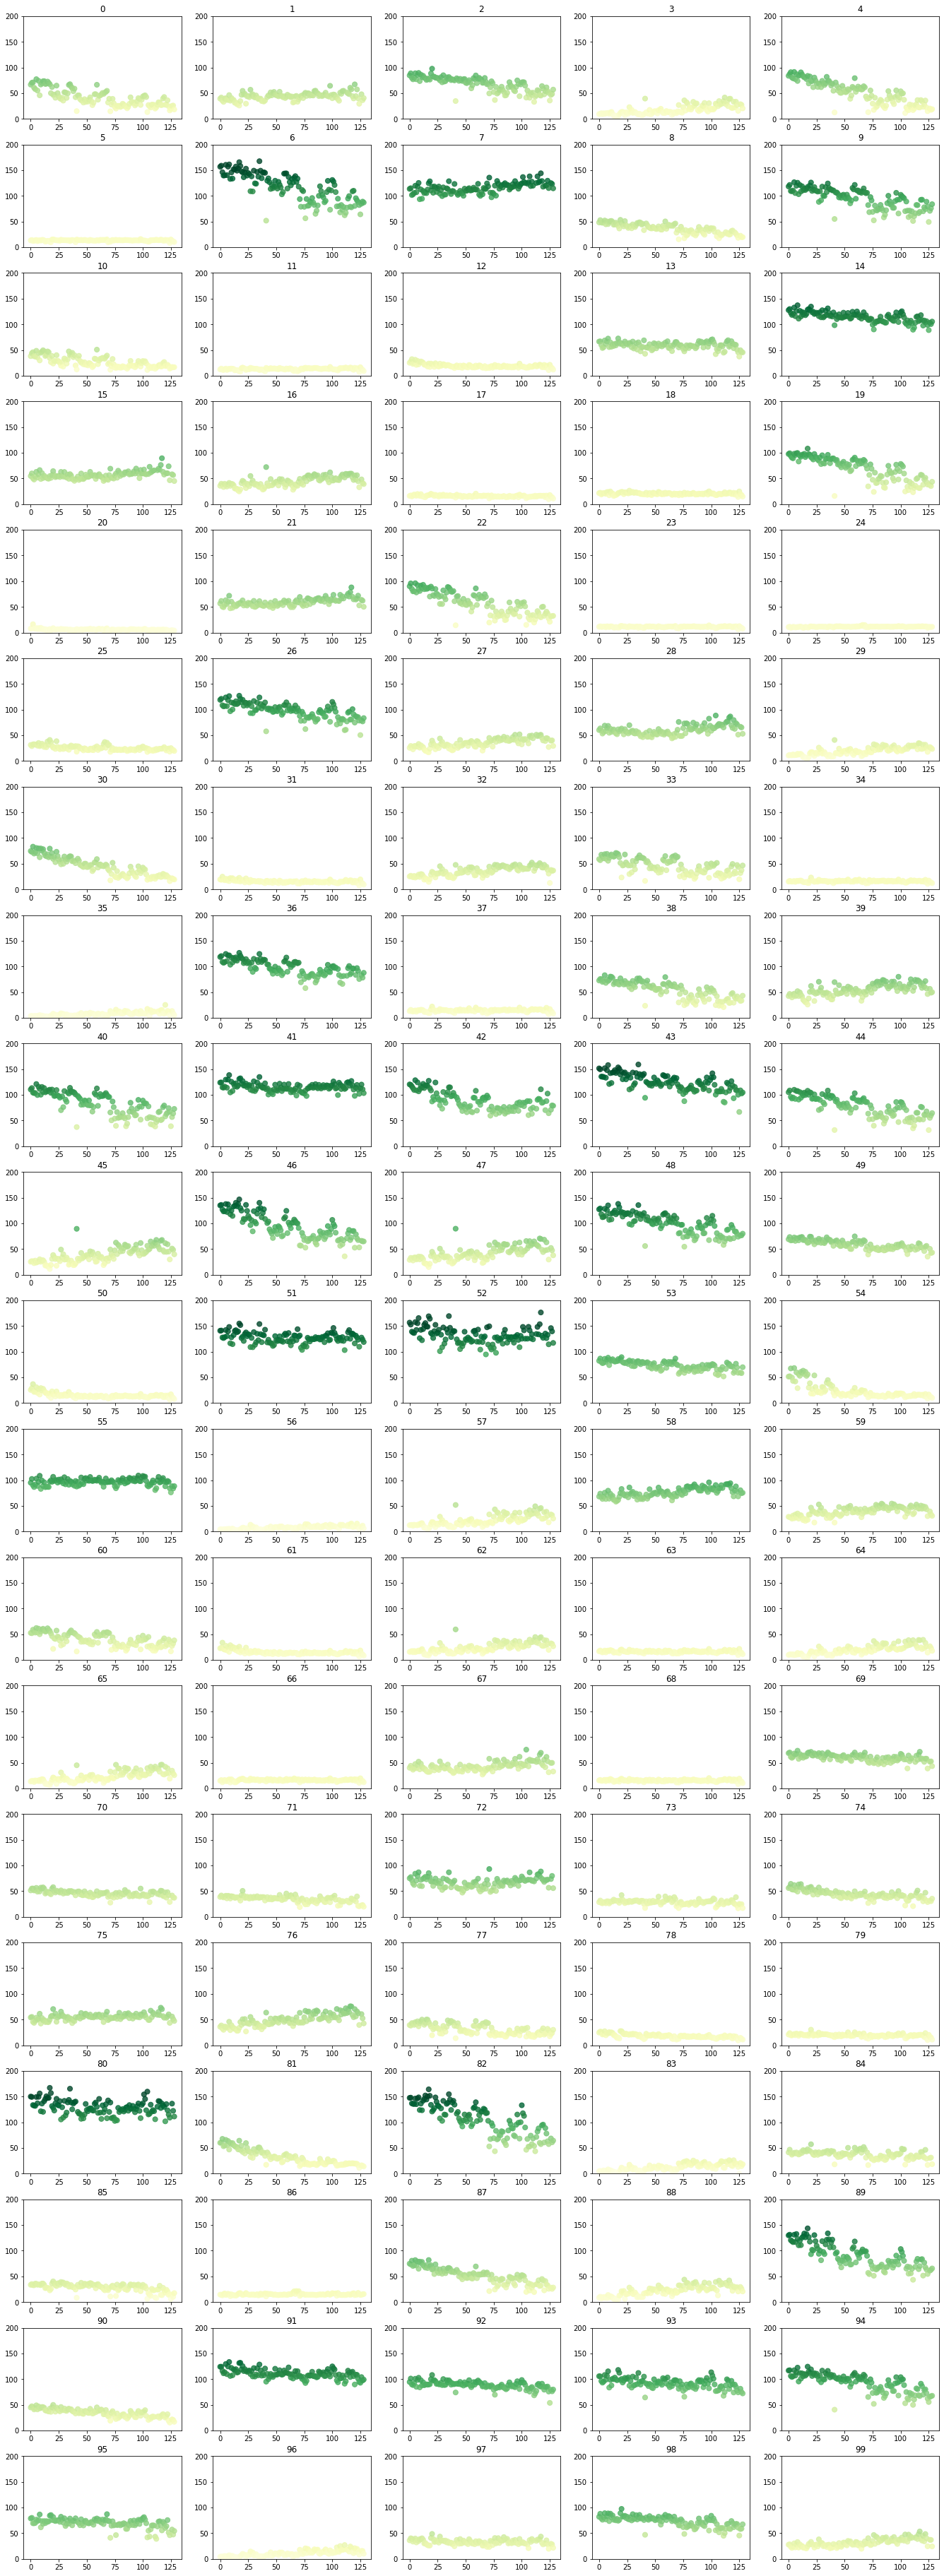

In [612]:
cultivars = np.arange(100)
sites = np.arange(129)

fig = plt.figure(figsize=(20,50))
for cvar in cultivars:
    ax = fig.add_subplot(20, 5, cvar+1)
    ax.scatter(list(sites), df_pca.iloc[cvar,:], alpha=0.8, s=50,
               c=df_pca.iloc[cvar,:], cmap=YlGn_9.mpl_colormap, vmin=0, vmax=150)

    ax.set_ylim(0, 200)
    ax.set_title(cvar)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.2, hspace=0.25)

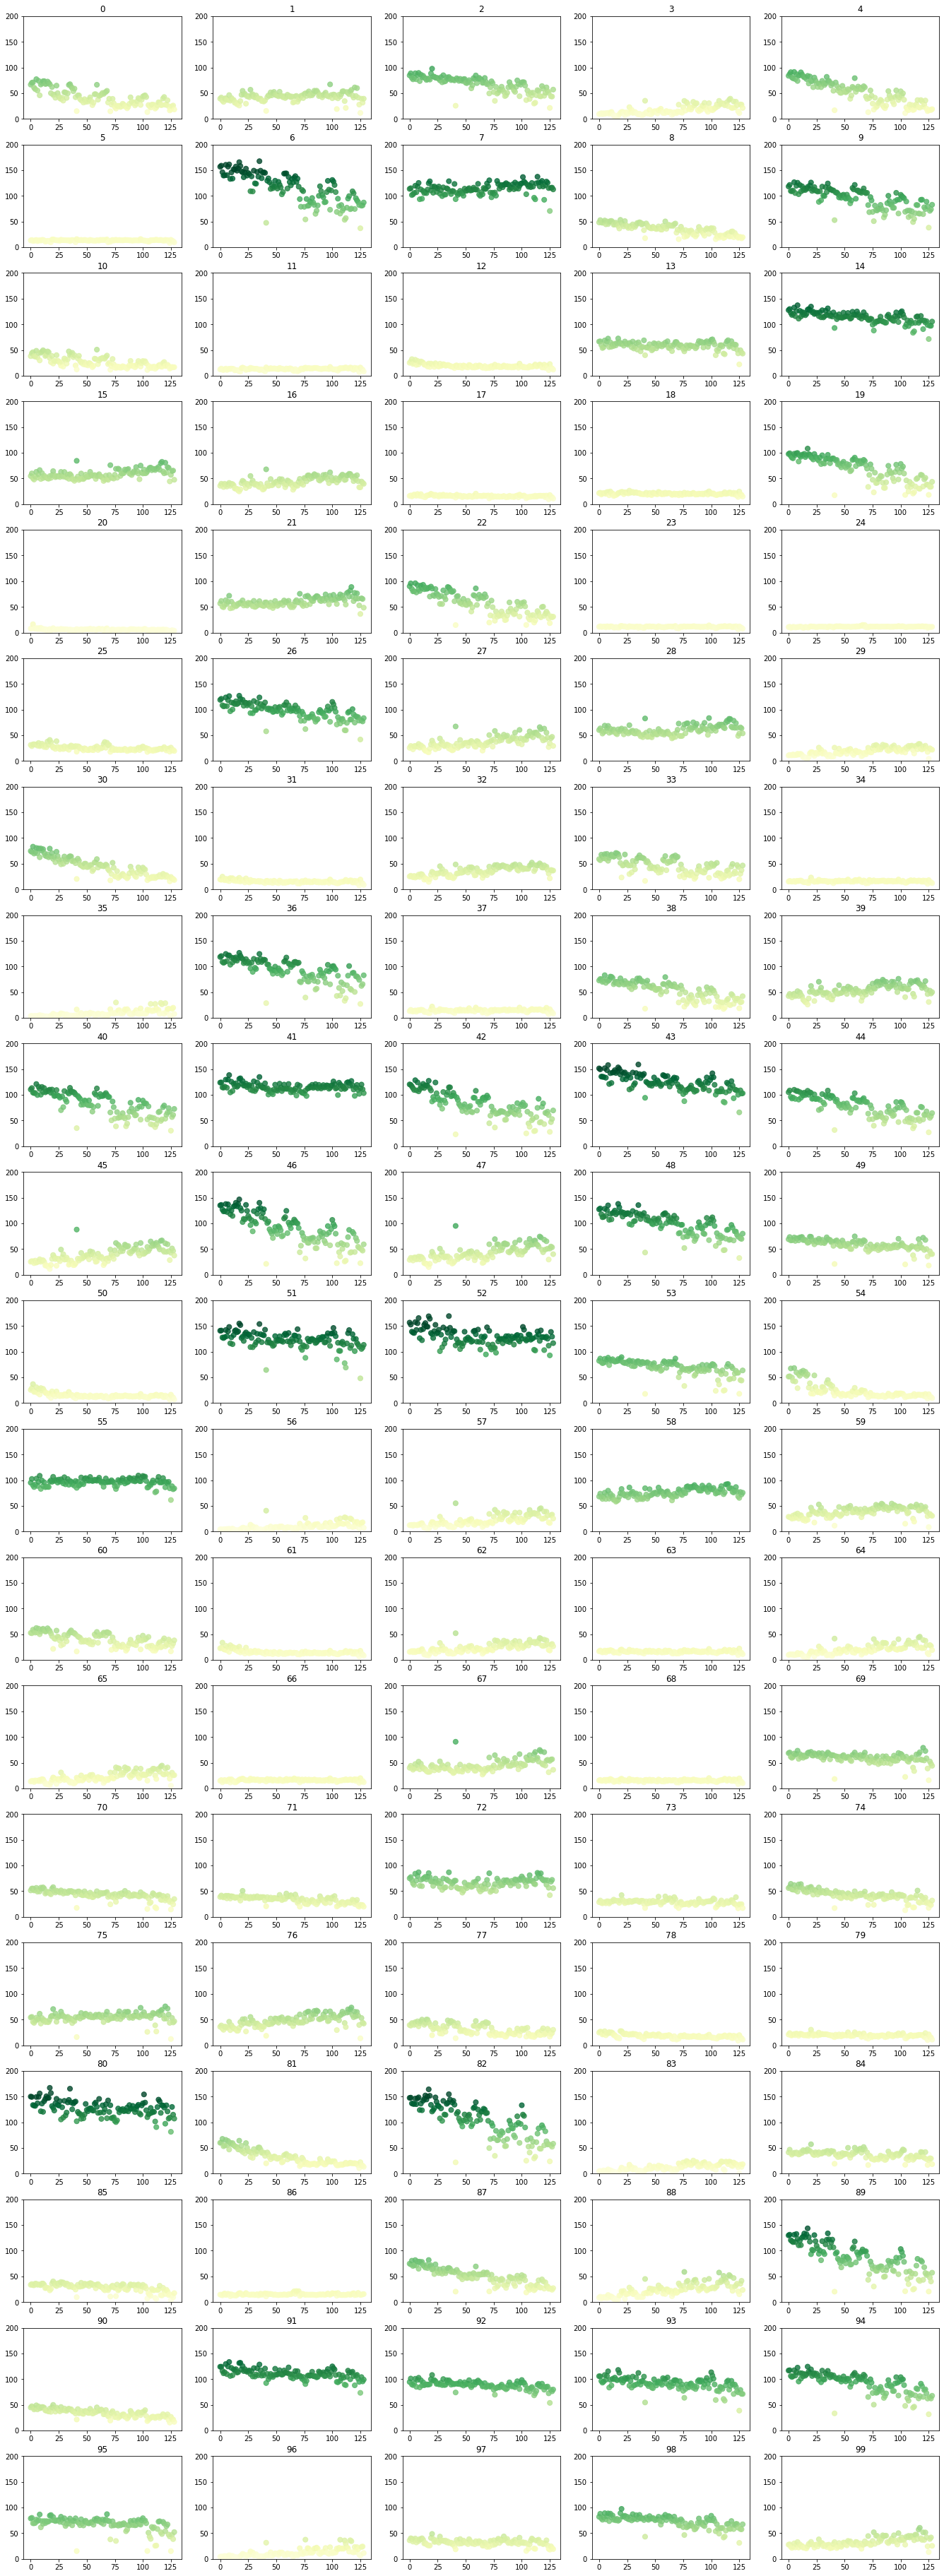

In [554]:
cultivars = np.arange(100)
sites = np.arange(129)

fig = plt.figure(figsize=(20,50))
for cvar in cultivars:
    ax = fig.add_subplot(20, 5, cvar+1)
    ax.scatter(list(sites), df_pca.iloc[cvar,:], alpha=0.8, s=50,
               c=df_pca.iloc[cvar,:], cmap=YlGn_9.mpl_colormap, vmin=0, vmax=150)

    ax.set_ylim(0, 200)
    ax.set_title(cvar)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.2, hspace=0.25)

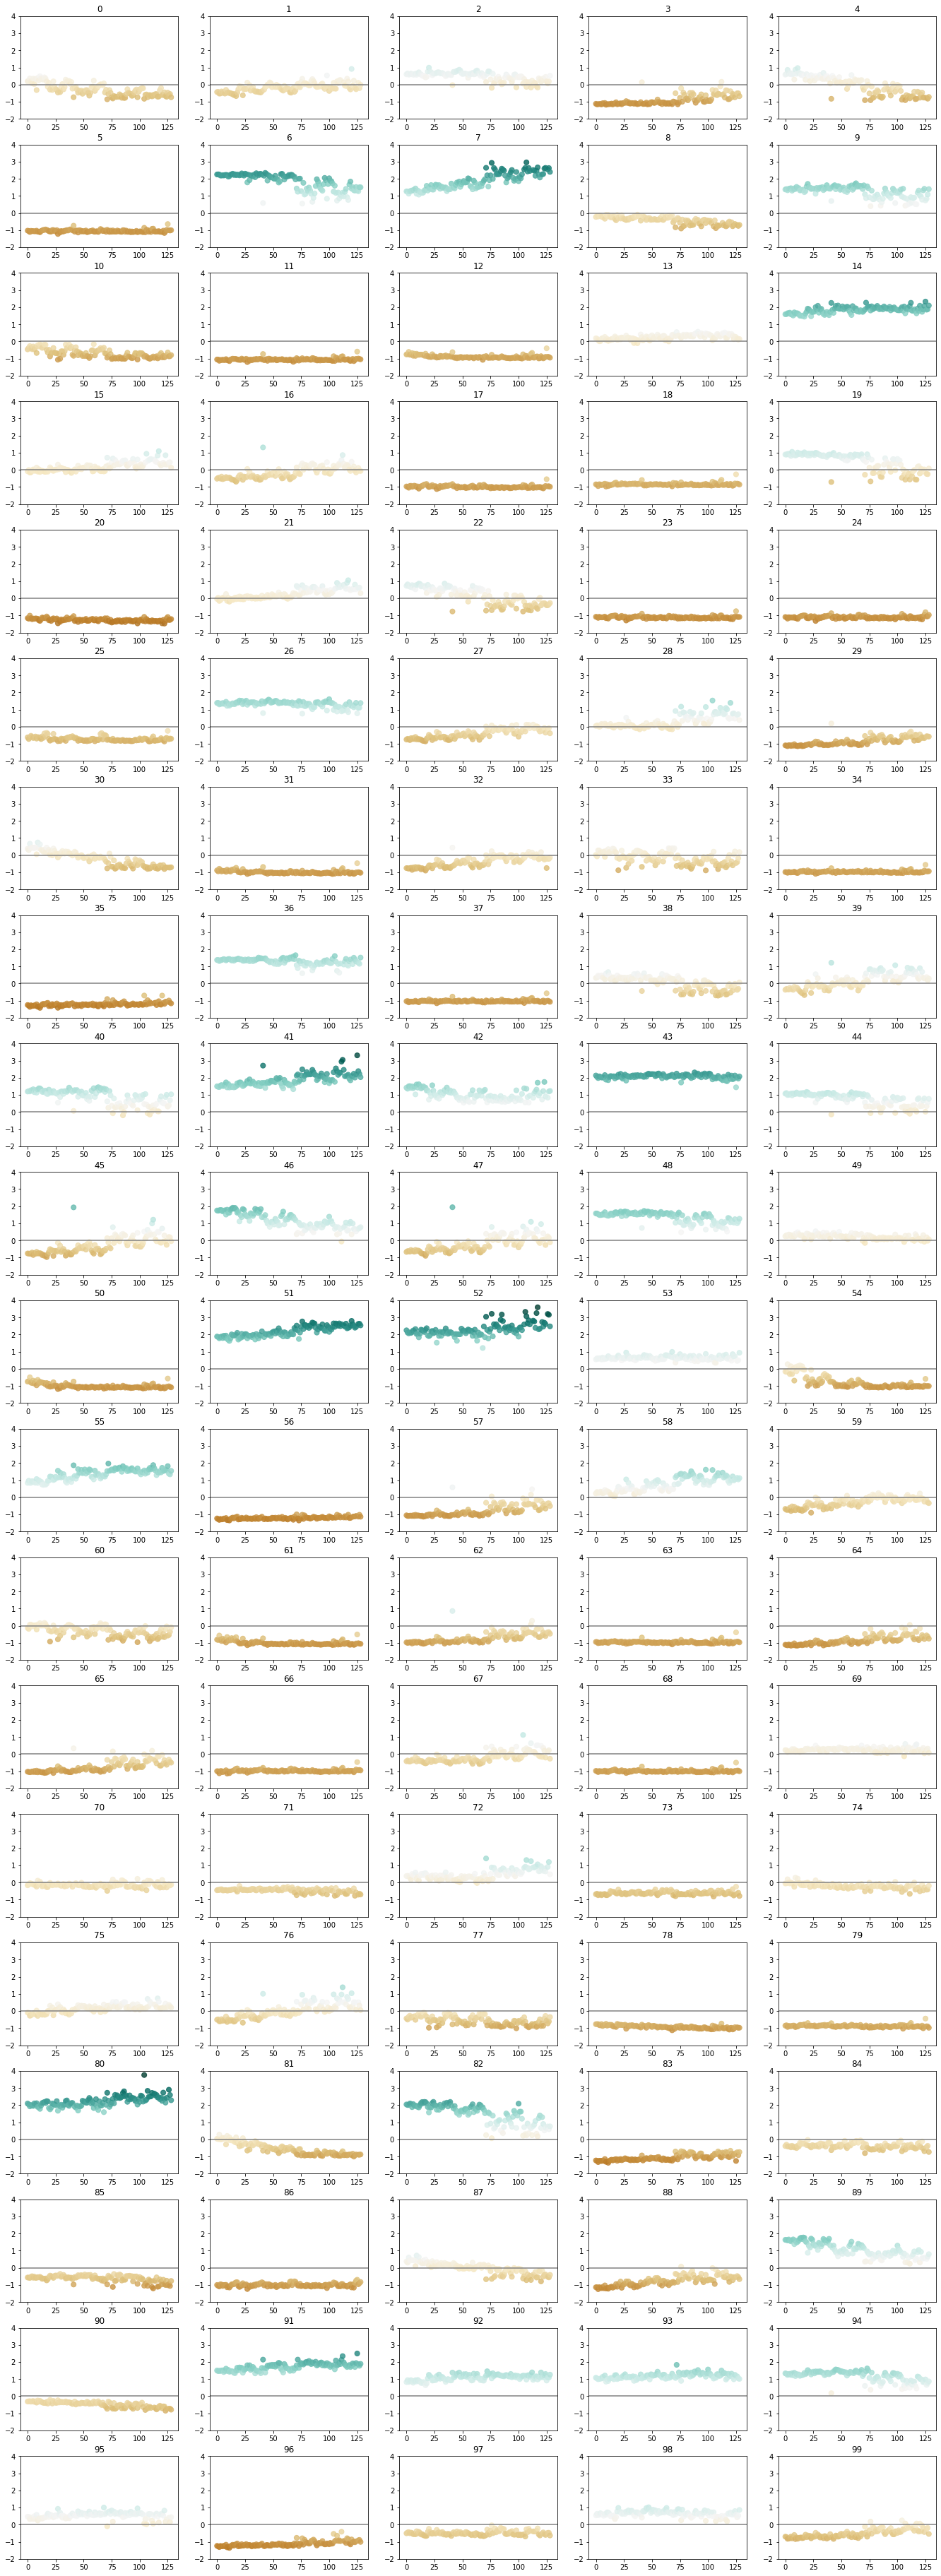

In [613]:
# matured only
cultivars = np.arange(100)
sites = np.arange(129)

fig = plt.figure(figsize=(20,50))
for cvar in cultivars:
    ax = fig.add_subplot(20, 5, cvar+1)
    ax.scatter(list(sites), ear_std_sites[cvar,:], alpha=0.8, s=50,
               c=ear_std_sites[cvar,:], cmap='BrBG', 
               vmin=-2.5, vmax=3.5)
    ax.set_ylim(-2, 4)
    ax.axhline(0, color='grey')
    ax.set_title(cvar)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.2, hspace=0.25)

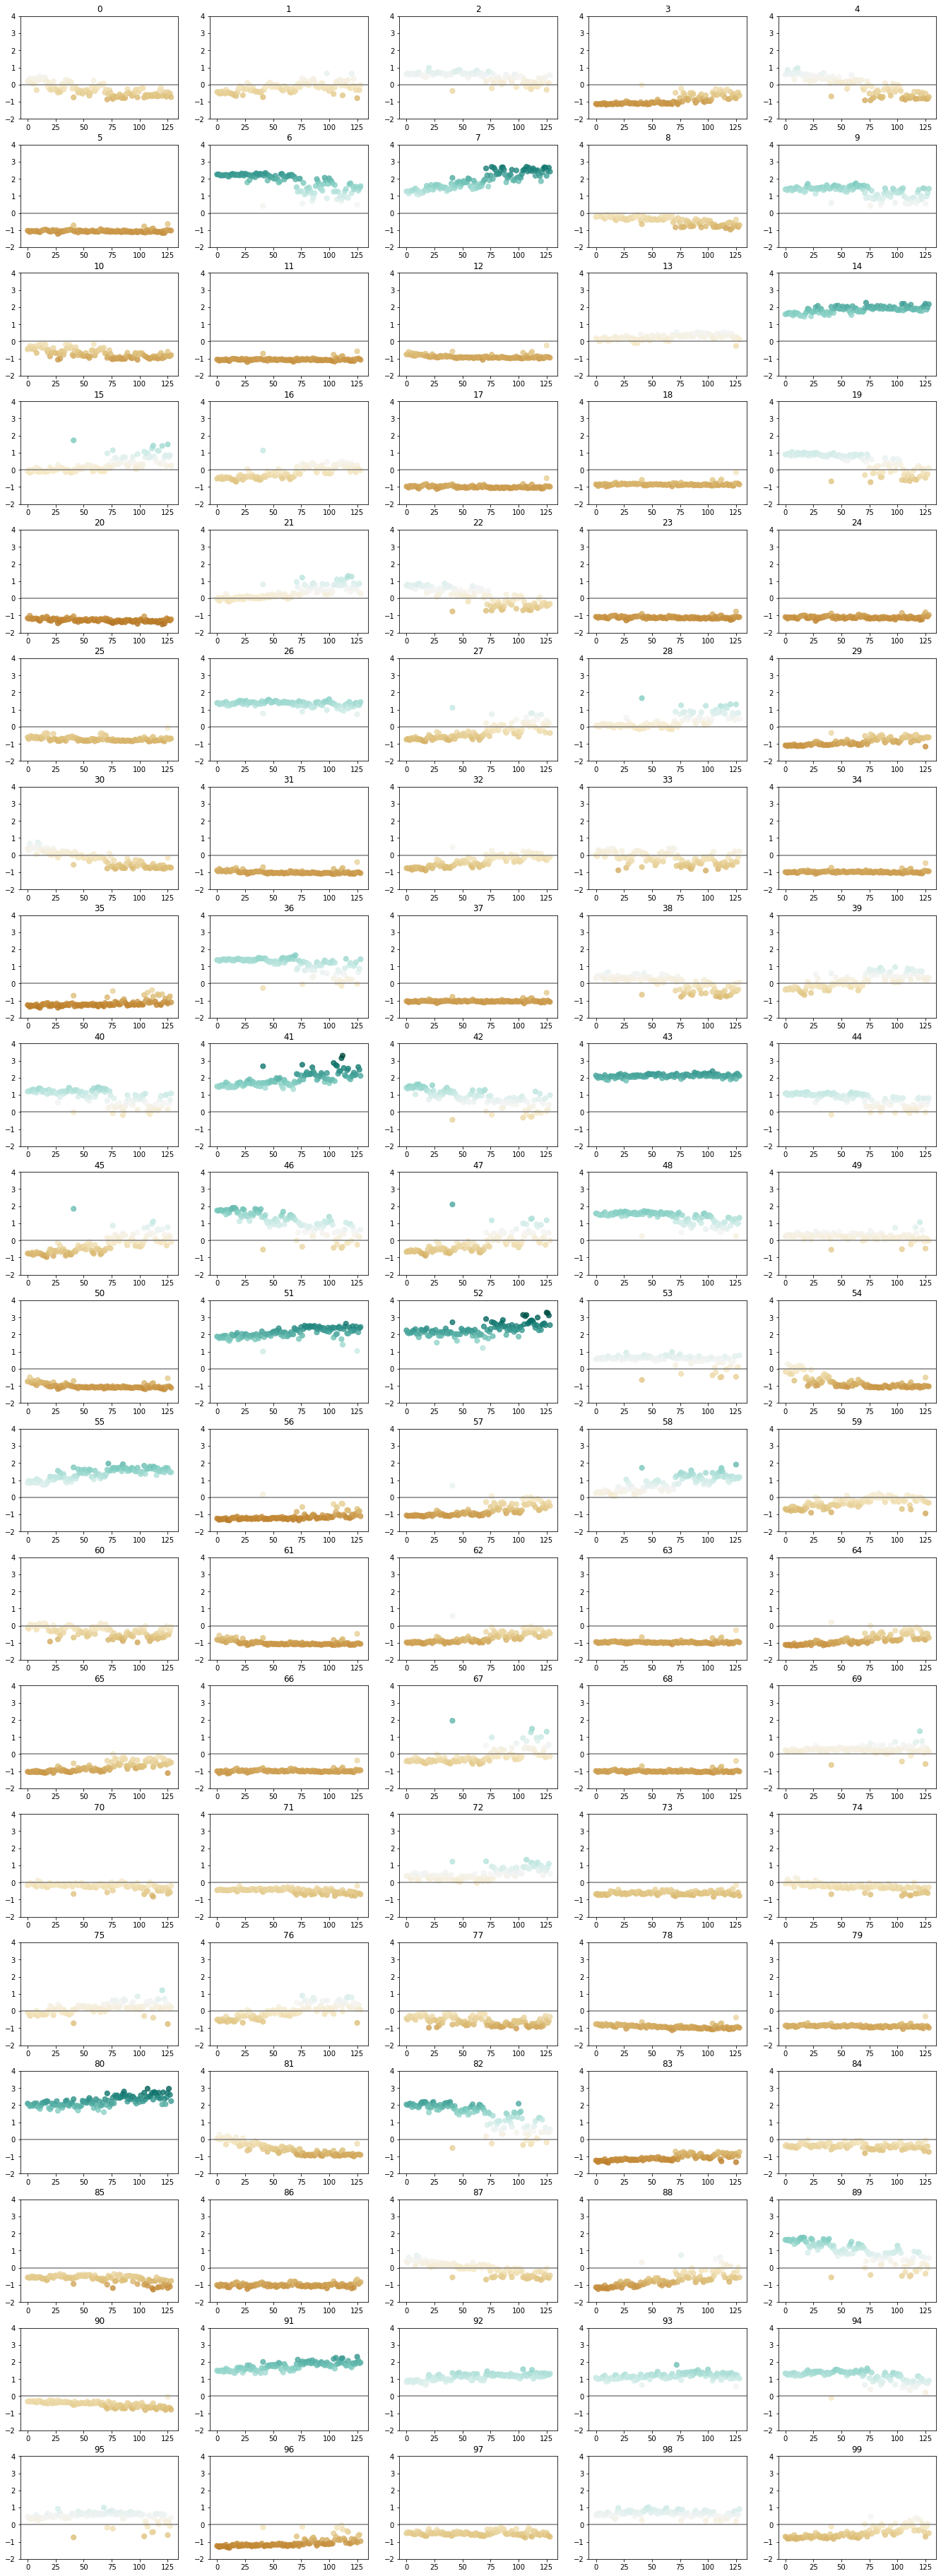

In [558]:
cultivars = np.arange(100)
sites = np.arange(129)

fig = plt.figure(figsize=(20,50))
for cvar in cultivars:
    ax = fig.add_subplot(20, 5, cvar+1)
    ax.scatter(list(sites), ear_std_sites[cvar,:], alpha=0.8, s=50,
               c=ear_std_sites[cvar,:], cmap='BrBG', 
               vmin=-2.5, vmax=3.5)
    ax.set_ylim(-2, 4)
    ax.axhline(0, color='grey')
    ax.set_title(cvar)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.2, hspace=0.25)

(array([23., 16., 12., 10., 10.,  7.,  4.,  8.,  5.,  5.]),
 array([-1.2501951 , -0.89994956, -0.54970402, -0.19945848,  0.15078706,
         0.5010326 ,  0.85127813,  1.20152367,  1.55176921,  1.90201475,
         2.25226029]),
 <BarContainer object of 10 artists>)

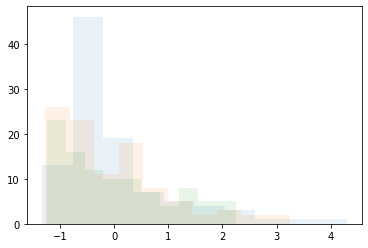

In [505]:
plt.hist(pd.DataFrame(ear_std_sites)[125], alpha=0.1)
plt.hist(pd.DataFrame(ear_std_sites)[126], alpha=0.1)
plt.hist(pd.DataFrame(ear_std_sites)[0], alpha=0.1)

In [614]:
# pca
#x = np.matrix(ear_std_sites)
x = np.matrix(df_pca)
#x = StandardScaler().fit_transform(x)
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDF = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# visualizing pca output
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 12, fontweight='light')
ax.set_ylabel('PC2', fontsize = 12, fontweight='light')
ax.scatter(principalDF.loc[:,'PC1'], principalDF.loc[:, 'PC2'], 
           c=pd.DataFrame(x).mean(axis=1),  # mean yield across sites for each cultivar
           s=80, alpha=0.7, cmap=YlGn_9.mpl_colormap)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [464]:
pca.explained_variance_ratio_

array([0.92380004, 0.06065323, 0.00531692, 0.00237919, 0.00210721])

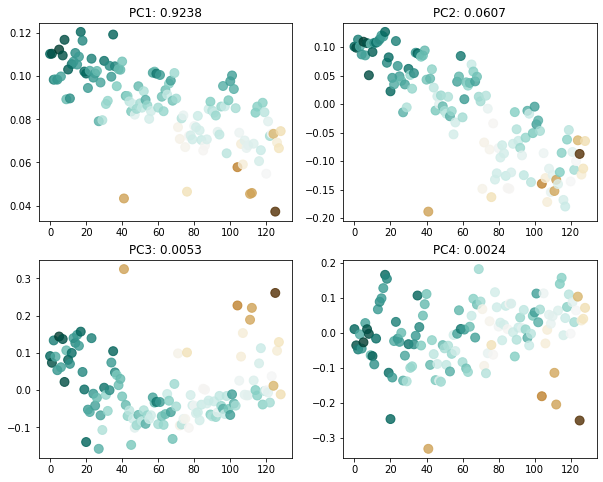

In [465]:
# component values with yield mean at each site
comps = [0,1,2,3]

fig, axs = plt.subplots(2, 2, figsize=(10,8))
for comp, ax in zip(comps, axs.flatten()):
    ax.scatter(np.arange(129), pca.components_[comp],
               c=pd.DataFrame(np.matrix(cvar_rows)).mean(axis=0),
               cmap='BrBG', alpha=0.8, s=80)
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')

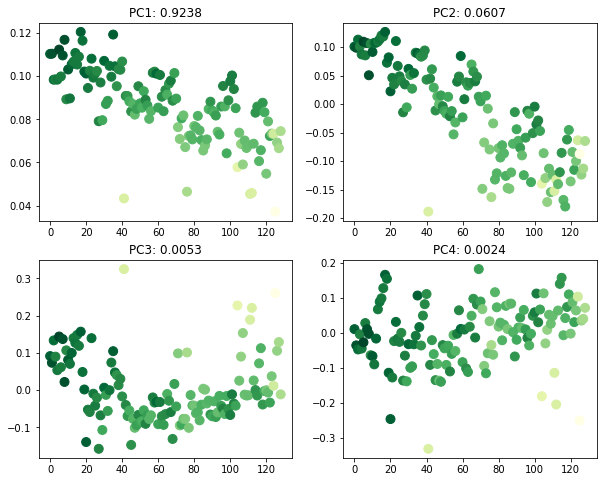

In [466]:
# component values with yield mean at each site
comps = [0,1,2,3]

fig, axs = plt.subplots(2, 2, figsize=(10,8))
for comp, ax in zip(comps, axs.flatten()):
    ax.scatter(np.arange(129), pca.components_[comp],
               c=pd.DataFrame(np.matrix(cvar_rows)).mean(axis=0),
               cmap=YlGn_9.mpl_colormap, s=80)
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')

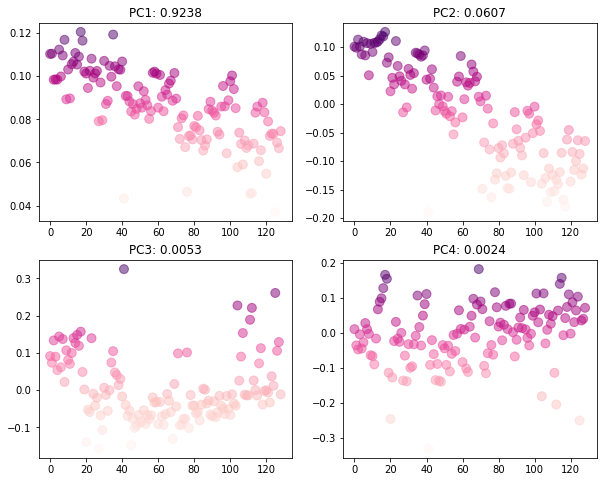

In [467]:
# component values
comps = [0,1,2,3]

fig, axs = plt.subplots(2, 2, figsize=(10,8))
for comp, ax in zip(comps, axs.flatten()):
    ax.scatter(np.arange(129), pca.components_[comp],
               c=pca.components_[comp], cmap='RdPu', s=80, alpha=0.5)
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')

/home/disk/eos8/ach315/anaconda3/envs/ideotype/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


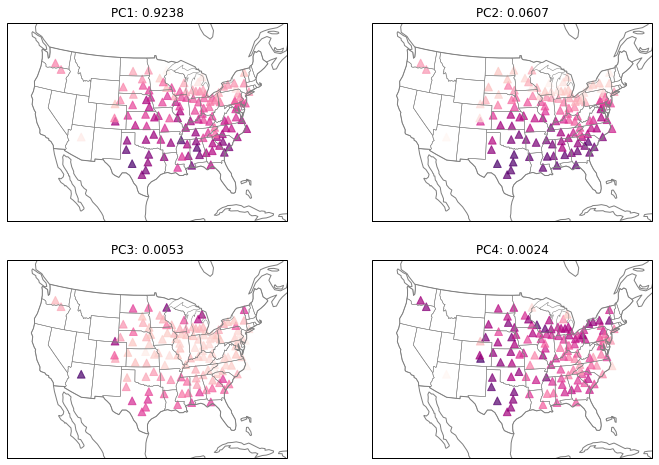

In [468]:
# projecting PC1 component values back onto map
comps = [0,1,2,3]
axnums = [1,2,3,4]

fig = plt.figure(figsize=(12,8))
for axnum, comp in zip(axnums, comps):
    ax = fig.add_subplot(2,2,axnum, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1],  # excluding last site that has no sim data
               transform=ccrs.PlateCarree(), s=60, marker='^',
               c=pca.components_[comp], alpha=0.7, cmap='RdPu')  # visualize PC1 components
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcamaps_onyield.pnb', format='png', dpi=800)

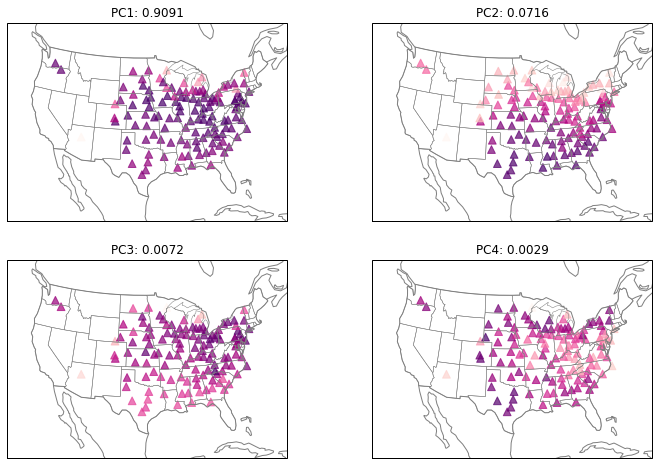

In [182]:
# projecting PC1 component values back onto map
comps = [0,1,2,3]
axnums = [1,2,3,4]

fig = plt.figure(figsize=(12,8))
for axnum, comp in zip(axnums, comps):
    ax = fig.add_subplot(2,2,axnum, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1],  # excluding last site that has no sim data
               transform=ccrs.PlateCarree(), s=60, marker='^',
               c=pca.components_[comp], alpha=0.7, cmap='RdPu')  # visualize PC1 components
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcamaps_onyield.pnb', format='png', dpi=800)

### consider all data

In [28]:
features = ['temp', 'rh', 'precip', 'solrad',
            'juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential']
target = 'dm_ear'

df_all[features].head()

temp         rh  precip      solrad  juv_leaves  stayGreen  rmax_ltir  \
0  22.527191  74.713304   881.8  234.060642          23       4.44       1.24   
1  22.527191  74.713304   881.8  234.060642          16       7.13       0.55   
2  22.527191  74.713304   881.8  234.060642          21       6.51       1.00   
3  22.527191  74.713304   881.8  234.060642          24       4.67       0.68   
4  22.527191  74.713304   881.8  234.060642          20       4.32       0.82   

   phyllo  LM_min  Vcmax   Vpmax    g1  ref_potential  
0    3.31   98.77  77.29   92.57  9.86          -3.38  
1    3.98   89.85  67.10   87.81  1.37          -2.83  
2    3.04   81.24  66.65   81.56  3.88          -2.63  
3    3.24   97.70  69.56   69.67  4.86          -3.63  
4    3.13  115.08  64.44  101.27  6.31          -3.40

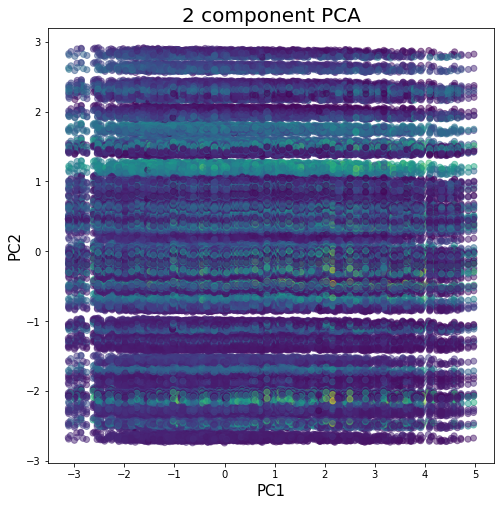

In [111]:
x = df_all.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_all.loc[:, target].values

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2'])
finalDF = pd.concat([principalDf, df_all.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, alpha=0.5)

In [88]:
pca.explained_variance_ratio_

array([0.14296356, 0.1348279 ])

### consider cultivar + site

In [145]:
features = ['temp', 'rh', 'precip', 'solrad',
            'juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential', 'dm_ear']
target = 'dm_ear'

df_pca = df_all.groupby(['cvar','site']).mean().reset_index()
df_pca[features].head()

temp         rh      precip      solrad  juv_leaves  stayGreen  \
0  23.448432  73.102946  741.059091  229.759914        23.0       4.44   
1  23.145051  75.116173  925.895500  229.412050        23.0       4.44   
2  23.636775  75.251082  898.192982  231.491352        23.0       4.44   
3  22.890561  71.303964  526.993939  230.217785        23.0       4.44   
4  22.125387  72.198567  533.709259  229.844983        23.0       4.44   

   rmax_ltir  phyllo  LM_min  Vcmax  Vpmax    g1  ref_potential     dm_ear  
0       1.24    3.31   98.77  77.29  92.57  9.86          -3.38  66.596818  
1       1.24    3.31   98.77  77.29  92.57  9.86          -3.38  70.157200  
2       1.24    3.31   98.77  77.29  92.57  9.86          -3.38  70.965263  
3       1.24    3.31   98.77  77.29  92.57  9.86          -3.38  60.676818  
4       1.24    3.31   98.77  77.29  92.57  9.86          -3.38  57.915000

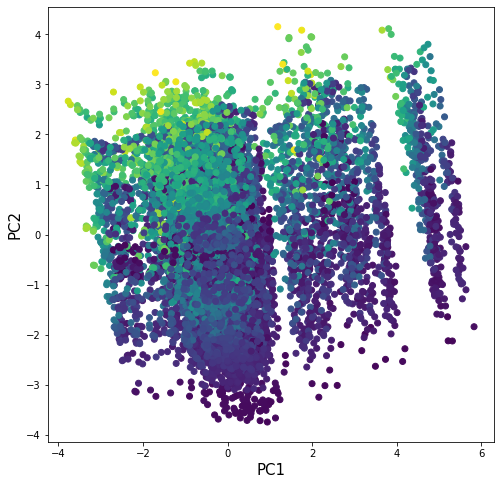

In [152]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                      '6','7','8','9','10'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear)

In [153]:
pca.explained_variance_ratio_

array([0.15097189, 0.13222293, 0.11936484, 0.10950949, 0.09304233,
       0.08090325, 0.06353001, 0.06168197, 0.05741092, 0.05258318])

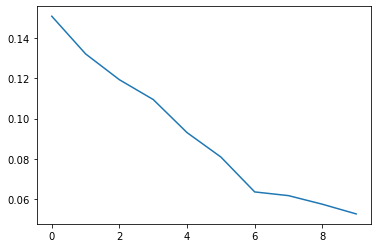

In [154]:
plt.plot(pca.explained_variance_ratio_)

In [149]:
features

['temp',
 'rh',
 'precip',
 'solrad',
 'juv_leaves',
 'stayGreen',
 'rmax_ltir',
 'phyllo',
 'LM_min',
 'Vcmax',
 'Vpmax',
 'g1',
 'ref_potential',
 'dm_ear']

In [155]:
pca.components_[0]

array([-0.30964336, -0.62928535, -0.62589057,  0.25467924,  0.03650071,
       -0.03255185, -0.03185394, -0.01510896, -0.04607925,  0.02910144,
        0.08831578,  0.00195146, -0.06214406, -0.18234578])

In [156]:
pca.components_[1]

array([ 0.13087557, -0.15834622, -0.09432931,  0.24596265, -0.31777997,
        0.13821015, -0.11516558,  0.08154836,  0.12044703, -0.13669719,
       -0.53432865, -0.17639471,  0.43845943,  0.45424722])

TODO: add a function that passes PCs in order of magnitude

### only consider parameter perturbation

In [160]:
features = ['juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential', 'dm_ear']
target = 'dm_ear'

In [161]:
df_pca = df_all.groupby(['cvar']).mean().reset_index()
df_pca.head()

cvar         year          jday       time     leaves  mature_lvs  \
0     0  1980.181709  29517.791534  12.172923  23.103187   23.101038   
1     1  1980.088953  29516.650393  12.880844  16.706678   16.705834   
2     2  1980.164577  29529.398302  12.503841  21.091156   21.090578   
3     3  1980.128299  29518.276898  12.710922  24.223435   24.219651   
4     4  1980.143841  29522.884522  12.571313  20.095016   20.092382   

    drop_lvs          LA      LA_dead       LAI  ...      precip      solrad  \
0  18.195687  331.044748  6145.241621  0.264808  ...  536.567101  220.066130   
1  13.762102  288.201196  2900.385999  0.230712  ...  540.124585  220.418624   
2  17.685402  230.336555  3759.799216  0.185419  ...  538.873725  220.129691   
3  19.543240  466.853967  6722.545185  0.373447  ...  538.918279  220.231846   
4  16.130065  388.388298  6207.974498  0.310656  ...  538.660827  220.182158   

        vpd   class_y   tzone_y      lat_y      lon_y    years_y  \
0  0.709642  1.029952 -5.611422  38.788779 -88.445692  22.040335   
1  0.713517  1.031030 -5.590401  38.587334 -88.169071  22.011585   
2  0.710236  1.030328 -5.599677  38.709954 -88.294296  22.026688   
3  0.711171  1.030451 -5.598863  38.687888 -88.285179  22.020706   
4  0.710686  1.030389 -5.599271  38.699001 -88.293961  22.021475   

         area_y  perct_irri_y  
0  16748.916846      6.579657  
1  16358.473921      6.463964  
2  16763.491728      6.442312  
3  16656.018074      6.464182  
4  16722.563506      6.469305  

[5 rows x 78 columns]

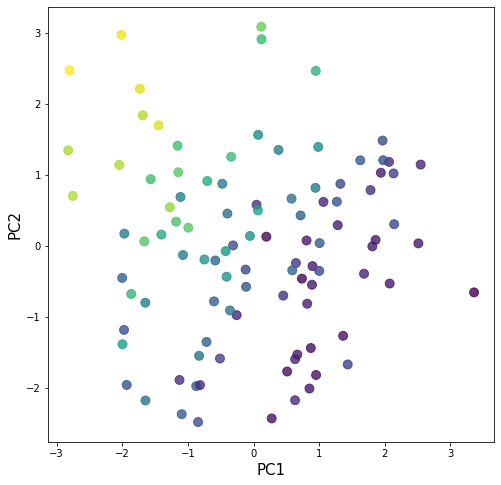

In [162]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, s=80, alpha=0.8)

In [140]:
pca.explained_variance_ratio_

array([0.186275  , 0.16442296, 0.13056456, 0.11358224, 0.08895631])

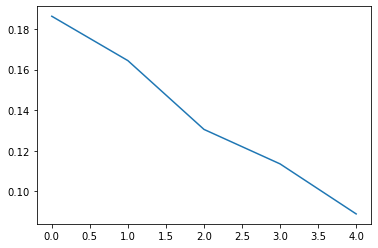

In [141]:
plt.plot(pca.explained_variance_ratio_)

In [142]:
features

['juv_leaves',
 'stayGreen',
 'rmax_ltir',
 'phyllo',
 'LM_min',
 'Vcmax',
 'Vpmax',
 'g1',
 'ref_potential',
 'dm_ear']

In [143]:
pca.components_[0]

array([ 0.32240334, -0.15663453,  0.07727223, -0.08913581, -0.15393197,
        0.15330794,  0.56404023,  0.16068079, -0.45505764, -0.5092838 ])

In [144]:
pca.components_[1]

array([ 0.23168985,  0.133916  ,  0.53829027,  0.02090634,  0.39235514,
       -0.15968644,  0.10114564,  0.44613812, -0.20699292,  0.45457099])

### Consider cultivar impace for single site

In [116]:
df_pca = df_all[df_all.site == '722070']

features = ['temp', 'rh', 'precip', 'solrad',
            'juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential']
target = 'dm_ear'

df_pca[features].head()

temp         rh  precip      solrad  juv_leaves  stayGreen  rmax_ltir  \
0  22.527191  74.713304   881.8  234.060642          23       4.44       1.24   
1  22.527191  74.713304   881.8  234.060642          16       7.13       0.55   
2  22.527191  74.713304   881.8  234.060642          21       6.51       1.00   
3  22.527191  74.713304   881.8  234.060642          24       4.67       0.68   
4  22.527191  74.713304   881.8  234.060642          20       4.32       0.82   

   phyllo  LM_min  Vcmax   Vpmax    g1  ref_potential  
0    3.31   98.77  77.29   92.57  9.86          -3.38  
1    3.98   89.85  67.10   87.81  1.37          -2.83  
2    3.04   81.24  66.65   81.56  3.88          -2.63  
3    3.24   97.70  69.56   69.67  4.86          -3.63  
4    3.13  115.08  64.44  101.27  6.31          -3.40

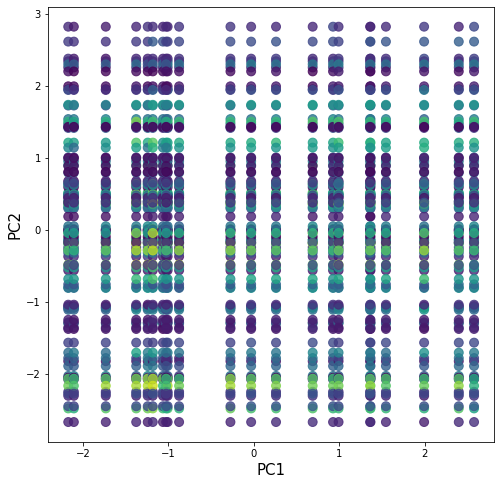

In [117]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, s=80, alpha=0.8)

### consider single site & year

In [112]:
df_pca = df_all[(df_all.site == '722070') & (df_all.year == 1961)]

features = ['juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential']
target = 'dm_ear'

df_pca[features].head()

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
0          23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
1          16       7.13       0.55    3.98   89.85  67.10   87.81  1.37   
2          21       6.51       1.00    3.04   81.24  66.65   81.56  3.88   
3          24       4.67       0.68    3.24   97.70  69.56   69.67  4.86   
4          20       4.32       0.82    3.13  115.08  64.44  101.27  6.31   

   ref_potential  
0          -3.38  
1          -2.83  
2          -2.63  
3          -3.63  
4          -3.40

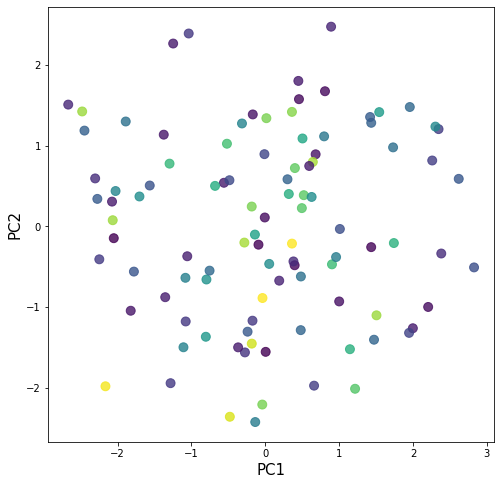

In [113]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, s=80, alpha=0.8)

In [108]:
pca.explained_variance_ratio_

array([0.19464533, 0.14838891, 0.13355437, 0.10865142, 0.09774583])